# Geoscripting Exercise 12 GISRSArtists
## 22 January 2019

Imports

In [1]:
from geopy.geocoders import Nominatim
import rasterio
import rasterstats as rs
import matplotlib.pyplot as plt
import geopandas as gpd
from owslib.wcs import WebCoverageService
from owslib.wfs import WebFeatureService
from python.createBoundingBox import createBoundingBox
from python.writeGeotiffToFile import writeGeotiffToFile
from python.getGeotiffFromWebCoverageService import getGeotiffFromWebCoverageService
from python.getDataFromWebFeatureService import getDataFromWebFeatureService
from python.calculateBuildingVolume import calculateBuildingVolume
from python.visualizeBuildingVolume import visualizeBuildingVolume
from python.geocodePlacenameToCoordinates import geocodePlacenameToCoordinates
from python.reproject import reproject

In [2]:
# get coordinates of Wageningen and reproject to RD New
wageningen = geocodePlacenameToCoordinates('Wageningen University')
x, y = reproject(wageningen, '4326', '28992')
print("coordinates: " + str(x) + ", " + str(y))

# create bounding box around Wageningen
bbox = createBoundingBox(x, y)
print("bbox: " + str(bbox))

# get wcs of Wageningen
url = 'http://geodata.nationaalgeoregister.nl/ahn2/wcs?service=WCS'
version = '1.0.0'
direc = 'data'
frmt = 'GEOTIFF_FLOAT32'
getGeotiffFromWebCoverageService(url, version, bbox, 
                                 'ahn2_05m_ruw', frmt, direc, 'AHN2_05m_DSM')
getGeotiffFromWebCoverageService(url, version, bbox, 
                                 'ahn2_05m_int', frmt, direc, 'AHN2_05m_DTM')


coordinates: 173994.1578792833, 444133.60329471016
bbox: (173494.1578792833, 443633.60329471016, 174494.1578792833, 444633.60329471016)


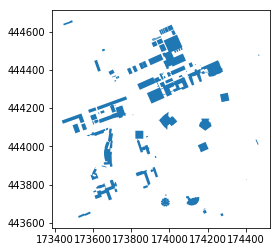

In [4]:
# get wfs of Wageningen
bgtURL = 'https://geodata.nationaalgeoregister.nl/beta/bgt/wfs'
bgtversion = '2.0.0'
typename = 'bgt:pand'
buildingsGDF = getDataFromWebFeatureService(bgtURL, bgtversion, bbox, typename)

%matplotlib inline 
buildingsGDF.plot() # plot to check if download succeeded

In [5]:
# create heightmodel from difference DSM and DTM
DSM = rasterio.open("./data/AHN2_05m_DSM.tif", driver="GTiff")
DTM = rasterio.open("./data/AHN2_05m_DTM.tif", driver="GTiff")
buildingsHeight = DSM.read() - DTM.read()

# save to geotif
kwargs = DSM.meta # Copy metadata of rasterio.io.DatasetReader
writeGeotiffToFile(buildingsHeight, 'output', 'buildingsHeight', kwargs)

In [6]:
# calculate volume of buildings
volume = calculateBuildingVolume(buildingsGDF, "buildingsHeight.tif", "output")
buildingsGDF['volume'] = volume
print(buildingsGDF['volume'].head()) # check output

/home/WUR/leens006/miniconda3/envs/rasterpython/lib/python3.7/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


0       80.395585
1    23346.082934
2    22038.836302
3     6064.847517
4       70.278633
Name: volume, dtype: float64


/home/WUR/leens006/miniconda3/envs/rasterpython/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


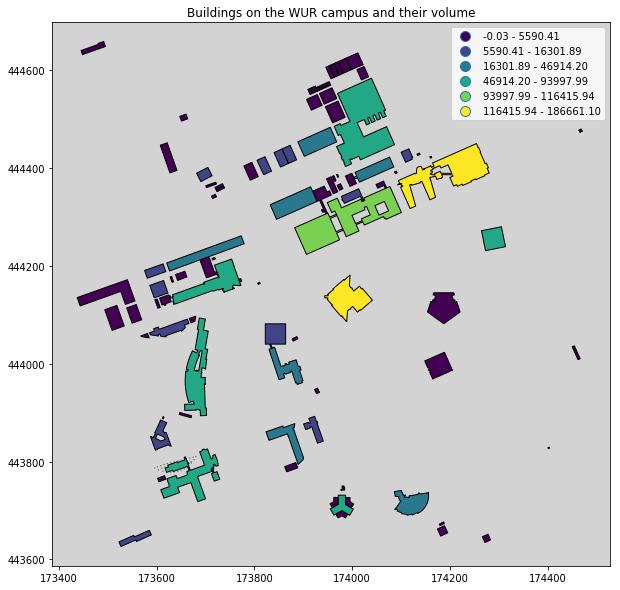

In [7]:
# plot buildingsvolume
visualizeBuildingVolume(buildingsGDF)
    